In [1]:
import cv2
import numpy as np
import imutils
import os
import matplotlib.pyplot as plt

In [2]:
os.chdir('../src')

from algos import card_utils,detect,img_utils,preprocessing

In [3]:
def find_corners(contour):

    corners = []
    for i in range(1, contour.shape[0] - 1):
        p1 = contour[i - 1]
        p2 = contour[i]
        p3 = contour[i + 1]

        v1 = p2 - p1
        v2 = p3 - p2

        cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        angle = np.arccos(cosine_angle)


        if np.degrees(angle) < 130 and np.degrees(angle) > 40: # Identify points not close to 180 degrees
            corners.append(p2)
    return corners



In [4]:
def find_corners_2(gray_img):
    print ('in type',gray_img.dtype,gray_img.shape)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Define the search window size (half of the side length)
    # A winSize of (5, 5) results in an 11x11 search window.
    winSize = (5, 5)

    # Define the zeroZone (optional, usually (-1, -1) for no zero zone)
    # This specifies a region in the center of the search window where no pixels are considered.
    zeroZone = (-1, -1)

    # Ensure corners are a float32 numpy array with the correct shape (n, 1, 2)
    # If your corners are (n, 2), you'll need to reshape them:
    # corners = corners.reshape(-1, 1, 2).astype(np.float32)
    corners = cv2.goodFeaturesToTrack(gray_img, 4, 0.1, 100,blockSize=20)

    # Refine the corner locations
    print ('c',corners)
    #return cv2.cornerSubPix(gray_img, corners, winSize, zeroZone, criteria)
    return corners

In [5]:
# too off center image_path = '../data/gpk-38b.webp'
# image_path = '../data/gpk-8a-psa.webp' # PSA
image_path = "../data/gpk-20b.webp"
image_path = "../data/gpk-37a.png"
image_path = "../data/gpk-16a.webp"  # grabs background
image_path = "../data/gpk-10b.webp"  # white back
image_path = "../data/gpk-12a.webp"  # sharp corners
#image_path = "../data/gpk-40b.webp"  # black back
#image_path = "../data/gpk-14b.webp"  # sharp corners
# image_path = '../data/gpk-9b.webp' #big top banner
#image_path = "../data/gpk-1b.webp"  # white back poor contour
#image_path = "../data/gpk-35a.webp"  # white back med
#image_path = "../data/gpk-22b.webp"  # thatch back poor corners
#image_path = "../data/gpk-41a.webp"  # black back lighting
#image_path = "../data/gpk-1b-2.webp"  # poor corners
#image_path = "../data/gpk-8b.webp"  # cant mask
#image_path = "../data/gpk-22a.webp" #checkerboard back
#image_path = "../data/gpk-29b.webp" #4 rounded corners
#image_path = "../data/gpk-8a.webp" #4 rounded corners
#image_path = "../data/gpk-17a.webp" #white back
#image_path = "../data/gpk-15b.webp" #white back terrible
#image_path = "../data/gpk-29b-2.webp" # bad corners
#image_path = "../data/gpk-6b.webp" #hand in back
#image_path = "../data/gpk-26b.webp" #sharp corners, good results
#image_path = "../data/gpk-4b.webp" # sharp corners, good results
#image_path = "../data/gpk-87b.webp"

image, mask, orig, contours, c_idx, opt_k = preprocessing.opt_border(
    image_path, max_iter=10, clahe=True, debug=False
)


c_img = np.full(image.shape, 0.0)
best_c_img = cv2.drawContours(c_img, contours, c_idx, (255, 0, 0), 2)
cs_img = np.full(image.shape, 0.0)
border_lines = preprocessing.get_straight_lines(
    best_c_img.astype(np.uint8), min_len=110, max_gap=20
)

for _i, _n in enumerate(contours):
    cs_img = cv2.drawContours(cs_img, contours, _i, (255, 0, 0), 2)

border_img = np.full(image.shape, 0.0)
border_ext_lines = []
for _n in border_lines:
    p1, p2 = _n
    p1, p2 = preprocessing.extend_line(np.asarray(p1), np.asarray(p2), 500)
    border_ext_lines.append((p1, p2))

int_pts = preprocessing.get_pt_intersections(
    border_ext_lines, exts=[[0, 0], [image.shape[1], image.shape[0]]]
)

for _n in int_pts:
    if _n[0] < 0 or _n[1] < 0:
        continue
    print("marking ", _n)
    cv2.drawMarker(
        border_img, _n, (250, 25, 10), cv2.MARKER_CROSS, markerSize=30, thickness=4
    )


tl, tr, bl, br = int_pts
warp_img = preprocessing.warp_image(orig, tl, tr, bl, br, extend=15)

tl_c, tr_c, bl_c, br_c, t_b, b_b, l_b, r_b = preprocessing.get_edges_corners(
    warp_img, extend=50
)

_, tl_c_m, _, border_c = preprocessing.get_border_mask(
    tl_c,
    quant_k=list(range(15, 3, -2)),
    blur=False,
    debug=False,
    clahe=True,
    remove_shadows=False,
    threshold_width=2,
)
_, br_c_m, _, _ = preprocessing.get_border_mask(
    br_c,
    quant_k=list(range(15, 3, -2)),
    border_color=border_c,
    reverse_border_walk=True,
    blur=False,
    clahe=True,
    debug=False,
    threshold_width=2,
)
_, tr_c_m, _, _ = preprocessing.get_border_mask(
    tr_c,
    quant_k=list(range(15, 3, -2)),
    border_color=border_c,
    blur=False,
    debug=False,
    clahe=True,
    remove_shadows=False,
    threshold_width=2,
)
_, bl_c_m, _, _ = preprocessing.get_border_mask(
    bl_c,
    quant_k=list(range(15, 3, -2)),
    border_color=border_c,
    reverse_border_walk=True,
    blur=False,
    clahe=True,
    debug=False,
    threshold_width=2,
)

tl_c_m_c = preprocessing.get_contours(tl_c_m)
br_c_m_c = preprocessing.get_contours(br_c_m)
bl_c_m_c = preprocessing.get_contours(bl_c_m)
tr_c_m_c = preprocessing.get_contours(tr_c_m)
# tl_c_score = preprocessing.find_best_right_angle(
#    preprocessing.get_uniform_contour(tl_c_m_c, min_area=150)[0]
# )
# br_c_score = preprocessing.find_best_right_angle(
#    preprocessing.get_uniform_contour(br_c_m_c, min_area=150)[0]
# )

print("contour counts ", len(tl_c_m_c), len(br_c_m_c))
# print("corner scores ", tl_c_score, br_c_score)

trying k  15
found border at  85 [255] [20]
border color 254, corner 0 lower thresh 253 upper thresh 255
winning cont area  22239.5
trying k  13
found border at  84 [255] [20]
border color 254, corner 0 lower thresh 253 upper thresh 255
winning cont area  7084.0
trying k  11
found border at  84 [255] [20]
border color 254, corner 0 lower thresh 253 upper thresh 255
winning cont area  7009.5
trying k  9
found border at  86 [255] [20]
border color 254, corner 0 lower thresh 253 upper thresh 255
winning cont area  8010.0
trying k  7
found border at  88 [255] [20]
border color 254, corner 0 lower thresh 253 upper thresh 255
winning cont area  1563256.0
exts  [[0, 0], [1200, 1600]]
marking  [71 42]
marking  [1118   42]
marking  [  56 1513]
marking  [1139 1513]
found border at  31 [255] [20]
border color 254, corner 0 lower thresh 252 upper thresh 256
border color 254, corner 255 lower thresh 252 upper thresh 256
border color 254, corner 0 lower thresh 252 upper thresh 256
border color 254, 

In [ ]:
h0_c, h1_c, v0_c, v1_c = preprocessing.scan_border(mask, 35, 35)
blank2 = np.full(image.shape, 0.0)
part_cont = cv2.drawContours(blank2, [h0_c, h1_c, v0_c, v1_c], 0, (255, 0, 0), 2)
part_cont = cv2.drawContours(part_cont, [h0_c, h1_c, v0_c, v1_c], 1, (255, 0, 0), 2)
part_cont = cv2.drawContours(part_cont, [h0_c, h1_c, v0_c, v1_c], 2, (255, 0, 0), 2)
part_cont = cv2.drawContours(part_cont, [h0_c, h1_c, v0_c, v1_c], 3, (255, 0, 0), 2)

tl_c_m_c_b = np.full(tl_c_m.shape, 0).astype(np.uint8)
_ctr, _idx, _area = preprocessing.get_max_contour(tl_c_m_c)
tl_c_m_c_b = cv2.drawContours(tl_c_m_c_b, tl_c_m_c, _idx, (255, 0, 0), 1)

br_c_m_c_b = np.full(br_c_m.shape, 0).astype(np.uint8)
_ctr, _idx, _area = preprocessing.get_max_contour(br_c_m_c)
br_c_m_c_b = cv2.drawContours(br_c_m_c_b, br_c_m_c, _idx, (255, 0, 0), 1)

tr_c_m_c_b = np.full(tr_c_m.shape, 0).astype(np.uint8)
_ctr, _idx, _area = preprocessing.get_max_contour(tr_c_m_c)
tr_c_m_c_b = cv2.drawContours(tr_c_m_c_b, tr_c_m_c, _idx, (255, 0, 0), 1)
print ('tr max cont',tr_c_m_c[_idx].shape,tr_c_m_c[_idx][0],tr_c_m_c[_idx][-1])
tr_c_m_c_b = np.full(tr_c_m.shape, 0).astype(np.uint8)
tr_c_m_c_b = cv2.drawContours(tr_c_m_c_b, tr_c_m_c, _idx, (255, 0, 0), 1)
tr_c_m_ic = preprocessing.get_ideal_corner_contour(tr_c_m_c_b,False,True,pixels=15)
print ('tr score',preprocessing.score_corner(tr_c_m_c[_idx],tr_c_m_ic))
ta = np.full(tr_c_m.shape, 0).astype(np.uint8)
cv2.drawContours(ta, [tr_c_m_ic,tr_c_m_c[_idx]], -1, (255, 0, 0), 1)

_ctr, _idx, _area = preprocessing.get_max_contour(bl_c_m_c)
print ('bl max cont',bl_c_m_c[_idx].shape,bl_c_m_c[_idx][0],bl_c_m_c[_idx][-1])
bl_c_m_c_b = np.full(bl_c_m.shape, 0).astype(np.uint8)
bl_c_m_c_b = cv2.drawContours(bl_c_m_c_b, bl_c_m_c, _idx, (255, 0, 0), 1)
bl_c_m_ic = preprocessing.get_ideal_corner_contour(bl_c_m_c_b,True,False,pixels=15)
print ('bl score',preprocessing.score_corner(bl_c_m_c[_idx],bl_c_m_ic))
tb = np.full(bl_c_m.shape, 0).astype(np.uint8)
cv2.drawContours(tb, [bl_c_m_ic,bl_c_m_c[_idx]], -1, (255, 0, 0), 1)


lines_0 = preprocessing.get_min_max_lines(
    preprocessing.get_major_lines(bl_c_m_c_b, 3, line_axis=0), True, 1
)
lines_1 = preprocessing.get_min_max_lines(
    preprocessing.get_major_lines(bl_c_m_c_b, 3, line_axis=1), False, 0
)

bl_c_m_c_b_6 = np.full(bl_c_m.shape, 0).astype(np.uint8)
cv2.line(bl_c_m_c_b_6, lines_0[0], lines_0[1], (255, 255, 0), 1)
cv2.line(bl_c_m_c_b_6, lines_1[0], lines_1[1], (255, 0, 255), 1)
cv2.line(bl_c_m_c_b, lines_0[0], lines_0[1], (255, 255, 0), 1)
cv2.line(bl_c_m_c_b, lines_1[0], lines_1[1], (255, 0, 255), 1)

lines_0 = preprocessing.get_min_max_lines(
    preprocessing.get_major_lines(tr_c_m_c_b, 3, line_axis=0), False, 1
)
lines_1 = preprocessing.get_min_max_lines(
    preprocessing.get_major_lines(tr_c_m_c_b, 3, line_axis=1), True, 0
)
tr_c_m_c_b_6 = np.full(tr_c_m.shape, 0).astype(np.uint8)
cv2.line(tr_c_m_c_b_6, lines_0[0], lines_0[1], (255, 255, 0), 1)
cv2.line(tr_c_m_c_b_6, lines_1[0], lines_1[1], (255, 0, 255), 1)
cv2.line(tr_c_m_c_b, lines_0[0], lines_0[1], (255, 255, 0), 1)
cv2.line(tr_c_m_c_b, lines_1[0], lines_1[1], (255, 0, 255), 1)

maxs 1 1541 17 1582
areas [45982.5 47273.5] [39763. 48642.]
tr max cont (115, 1, 2) [[ 5 12]] [[ 5 13]]
pts shape (115, 1, 2)
pts shape (4, 1, 2)
tr score 0.28
bl max cont (43, 1, 2) [[16  0]] [[99  0]]
pts shape (43, 1, 2)
pts shape (4, 1, 2)
bl score 0.52


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(100, 100), dtype=uint8)

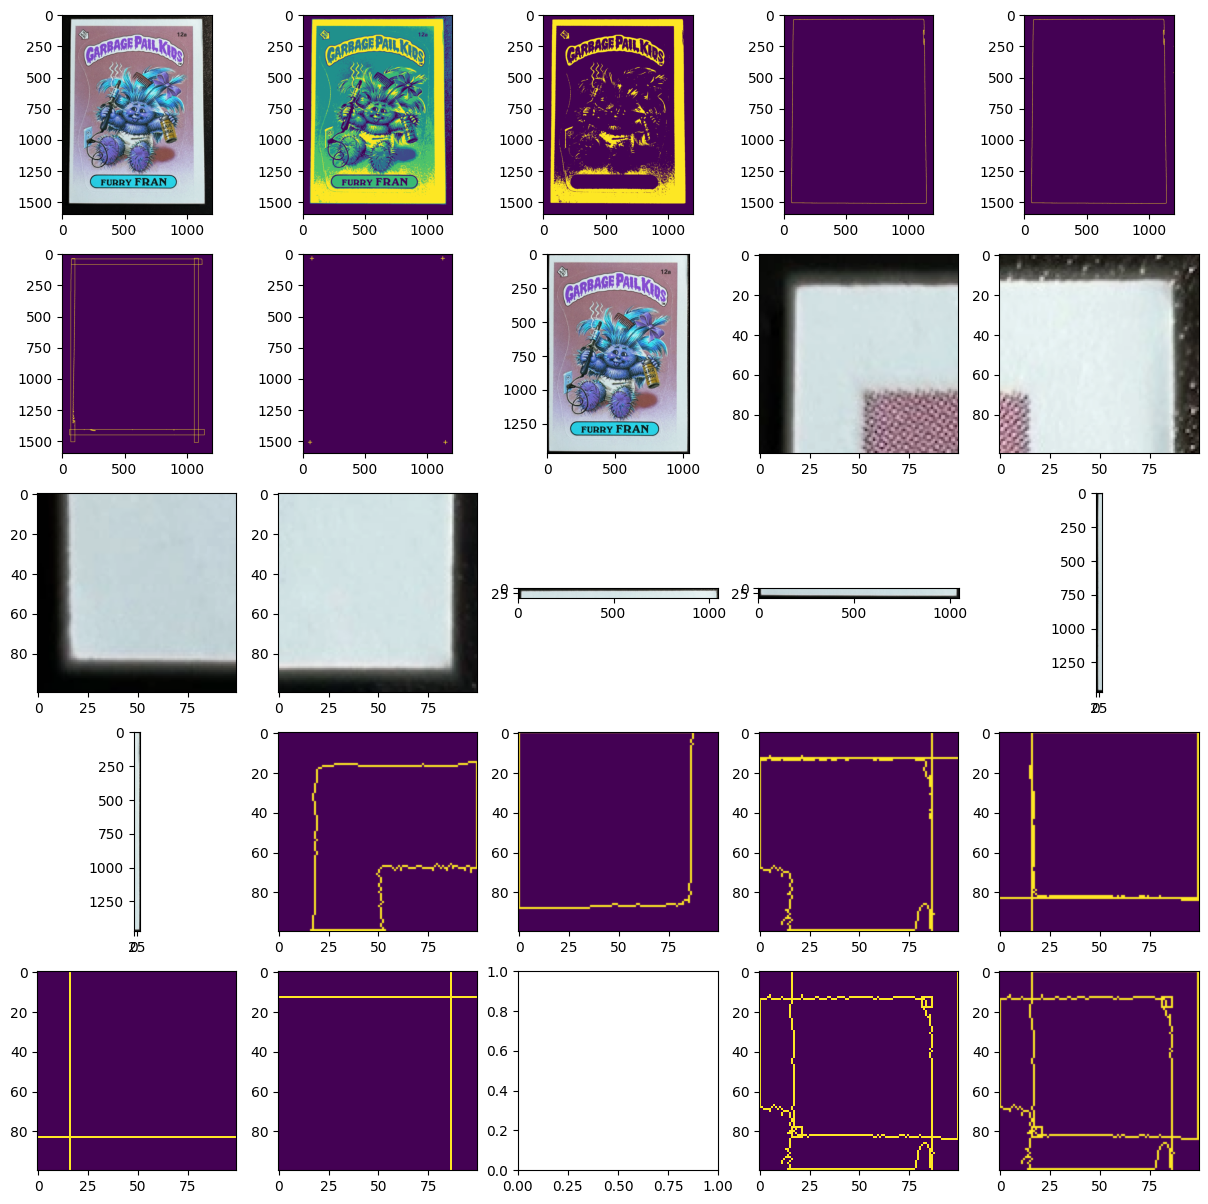

In [11]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=(15,15))

ax[0,0].imshow(orig)
ax[0,1].imshow(image)
ax[0,2].imshow(mask)
ax[0,3].imshow(best_c_img)
ax[0,4].imshow(cs_img)

ax[1,0].imshow(part_cont)
ax[1,1].imshow(border_img)
ax[1,2].imshow(warp_img)

ax[1,3].imshow(tl_c)
ax[1,4].imshow(tr_c)
ax[2,0].imshow(bl_c)
ax[2,1].imshow(br_c)
ax[2,2].imshow(t_b)
ax[2,3].imshow(b_b)
ax[2,4].imshow(l_b)

ax[3,0].imshow(r_b)
ax[3,1].imshow(tl_c_m_c_b)
ax[3,2].imshow(br_c_m_c_b)
ax[3,3].imshow(tr_c_m_c_b)
ax[3,4].imshow(bl_c_m_c_b)

ax[4,0].imshow(bl_c_m_c_b_6)
ax[4,1].imshow(tr_c_m_c_b_6)
ax[4,-2].imshow(ta)
ax[4,-1].imshow(ta)